In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [2]:
filename=joinpath(dirname(abspath(@__FILE__)),"..","sample","CAT_eq_ods.json")
dd = IMAS.json2imas(filename);
IMAS.flux_surfaces(dd.equilibrium);

In [314]:
ϵ = 0.32
κ = 1.7
δ = -0.3
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

dd = IMAS.dd()
resize!(dd.equilibrium.time_slice,1)
FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2));
dd.equilibrium.time=[0.0]
dd.equilibrium.vacuum_toroidal_field.r0=R0
dd.equilibrium.vacuum_toroidal_field.b0=[B0]

plot(dd.equilibrium.time_slice[1]);

  0.887809 seconds (3.87 M allocations: 145.344 MiB, 59.08% gc time)


 38.928409 seconds (102.27 M allocations: 6.454 GiB, 3.22% gc time, 54.67% compilation time)


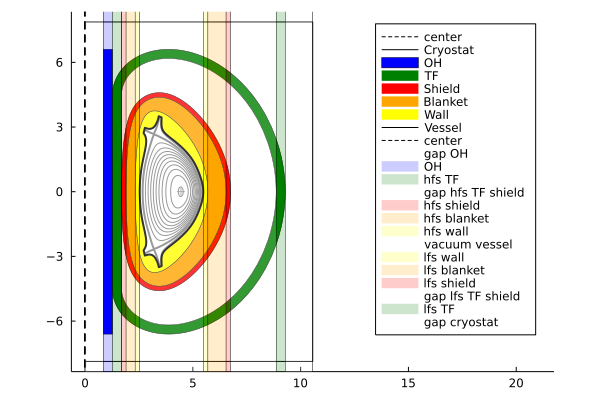

In [3]:
# initialize and run radial build actor
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]
@time rbactor = FUSE.init(rb, eqt, is_nuclear_facility=true, conformal_wall=true);
FUSE.step(rbactor)
dd.radial_build = FUSE.finalize(rbactor)

plot(eqt,color=:gray)
plot!(rb,outline=true)
display(plot!(rb,outline=false))

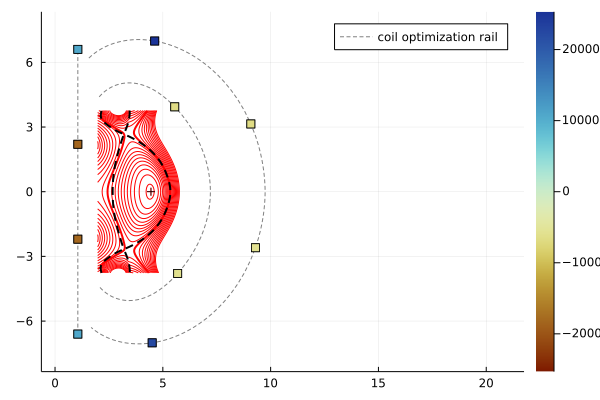

In [126]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium,dd.radial_build, 4, [2,4], 1E-13);

plot(pfoptactor)

# plot(eqt,color=:gray)
# plot!(rb)
# #plot!(rb,outline=false)
# display(plot!(pfoptactor,equilibrium=false))
# # plot!(pfoptactor.pf_active,color=:magenta)
# #plot(rb)
# #display(plot!(pfoptactor))

In [ ]:
# run pf actor
FUSE.step(pfoptactor, λ_currents=1E6, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:rail);
plot(rb)
display(plot!(pfoptactor))

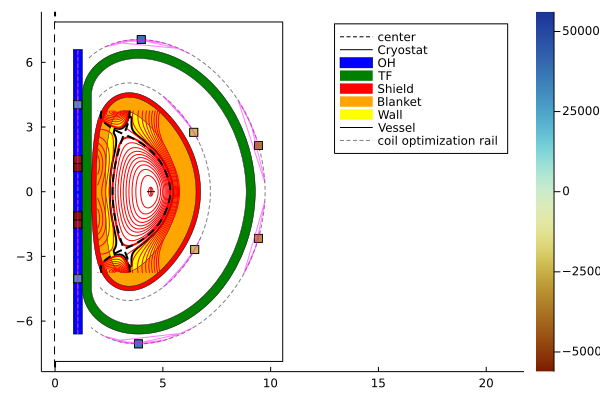

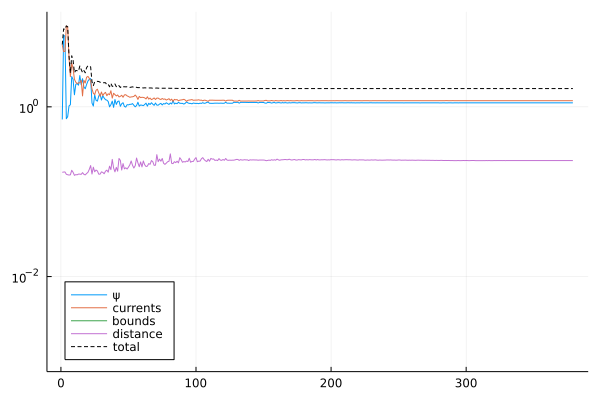

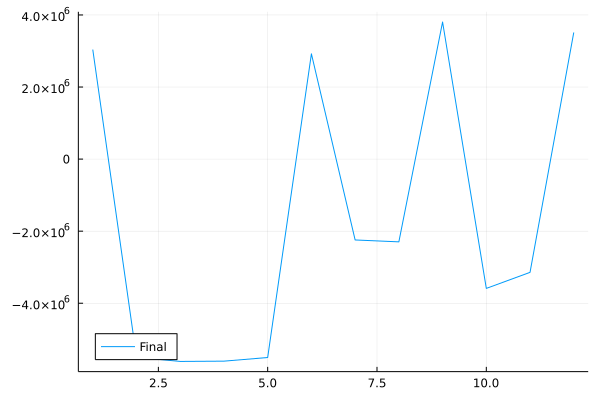

In [123]:
plot(rb)
display(plot!(pfoptactor,equilibrium=true,trace=true))

display(plot(pfoptactor.trace,:cost,start_at=1,yscale=:log10,ylim=[1E-3,1E1]))

display(plot(pfoptactor.trace,:final_currents))